The purpose of this script is to see what fine-tuning the GloVe embedding is like - how can we visualize changes, how different types of data lead to different representations, and how this manifests itself in clues. For example, we will have original GloVe, fine-tuned GloVe, and compare the distribution of clues. Questions for consideration:
1. How can we visualize and understand the impact on GloVe? Improvements in the loss function, histogram of components
2. Are we fine tuning all of GloVe? Or only the 180 words that are in our boardgame?

As a first attempt, lets just import GloVe as exists, add some random noise, and see how this effects our predictions?

In [7]:
# Same as before, import top 50000 words from GloVe
import copy
from random import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import spatial
embeddings_all = {}
with open("./top_50000.txt", 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        if len(word) > 1: 
            vector = np.asarray(values[1:], "float32")
            embeddings_all[word] = vector

In [8]:
# Same as before, generates a list of all the codenames words
codenames_words = []
with open("./codenames_words.txt", 'r') as f:
    for line in f:
        codenames_words.append(line.strip())

In [9]:
# Same as before, chooses a smaller subset of the original 50000 embeddings. Also, add codenames words
def embeddings_size(embeddings_size, embeddings_all):
    #embeddings_size is the length of the subset of embeddings
    #embeddings_all is the embeddings from 50k top words
    embeddings = {}
    for x in list(embeddings_all)[0:embeddings_size]:
        embeddings[x] = embeddings_all[x]
    
    #adds words from codenames that don't make it in the top XX words
    for item in codenames_words:
        if item not in embeddings:
            embeddings[item] = embeddings_all[item]
            
    return embeddings

In [15]:
# Modify embeddings. This will involve modifying only the codenames embeddings, at first with a random number
def modify_embeddings(embeddings):
    new_embeddings = copy.deepcopy(embeddings) #need a deep copy to make new embeddings, otherwise both dictionaries will change when we modify one
    for key in new_embeddings:
        if key in codenames_words:
            new_embeddings[key] += random()
            #this will only slightly modify embeddings of key codenames words 

    return new_embeddings

In [24]:
#Actuall run function defined above!
embeddings_10000 = embeddings_size(10000, embeddings_all) #Just as before, embeddings of top 10000 words plus codenames words
embeddings_10000_modified  = modify_embeddings(embeddings_10000) #Now, add random noise to the representation of the codenames words

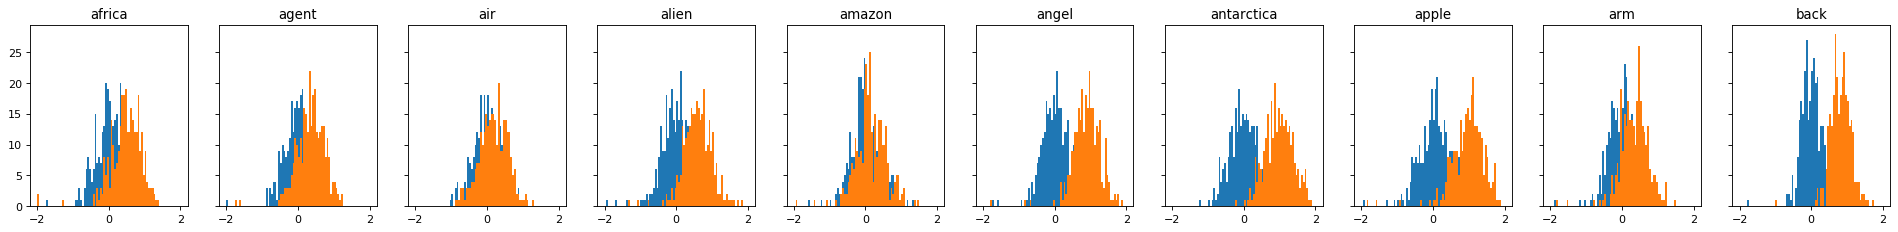

In [25]:
#This plots histograms of the different components of the GloVe vector for each word before and after noise
#Here, orange represents the new modified embeddings, while blue represents the original embeddings
fig, axs = plt.subplots(1, 10, sharey=True, figsize=(30, 3), dpi=80,)
for i in range(0, 10):
    data_original = embeddings_10000[codenames_words[i]]
    data_modified = embeddings_10000_modified[codenames_words[i]]
    axs[i].hist(data_original, bins=np.arange(-2, 2 + .05, .05)) 
    axs[i].hist(data_modified, bins=np.arange(-2, 2 + .05, .05)) 
    axs[i].title.set_text(codenames_words[i])
plt.show()

Probably at this point we should come up with a nice pipeline to take a .txt file of embeddings and generate and compare clues. For now, I will just copy and paste the remaining code from the data_collection notebook...

In [27]:
# Helper Functions

#Returns a distance between two vectors ranging between 0 and 1
def distance(embeddings, word, reference):
    return spatial.distance.cosine(embeddings[word], embeddings[reference])

#Returns a list of keys (here words) sorted by their distance from reference
def closest_words(embeddings, reference):
    return sorted(embeddings.keys(), key=lambda w: distance(embeddings, w, reference))

#Returns goodness of an answer. Positive is better?
def goodness(embeddings, word, answers, bad):
    if word in answers + bad: return -999
    return sum([distance(embeddings, word, b) for b in bad]) - 4.0 * sum([distance(embeddings, word, a) 
                                                                          for a in answers])

def minimax(embeddings, word, answers, bad):
    if word in answers + bad: return -999
    return min([distance(embeddings, word, b) for b in bad]) - max([distance(embeddings, word, a) for a in answers])

def candidates(embeddings, answers, bad, size=10):
    best = sorted(embeddings.keys(), key=lambda w: -1 * goodness(embeddings, w, answers, bad))
    res = [(str(i + 1), "{0:.2f}".format(minimax(embeddings, w, answers, bad)), w) 
           for i, w in enumerate(sorted(best[:250], key=lambda w: -1 * minimax(embeddings, w, answers, bad))[:size])]
    
    # Modified to only return the top candidates rather than the scores since that's not important
    return [c[2] for c in res]

In [28]:
# Functions to help with word + scores (not necessary for data collection)...
from itertools import zip_longest

def grouper(n, iterable, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(fillvalue=fillvalue, *args)

def tabulate(data):
    data = list(grouper(10, data))
    return data

In [48]:
from random import sample
    
def generate_single_example(codenames_words, embeddings1, embeddings2):
    # Generates a single example (good words, bad words, top ten clues)
    good = sample(codenames_words, 3)
    bad = sample(codenames_words, 6)

    clues1 = candidates(embeddings1, good, bad)
    clues2 = candidates(embeddings2, good, bad)

    print('\n Good words are', good, '\n Bad words are', bad, '\n Clues 1 are', clues1, '\n Clues 2 are', clues2)

In [50]:
generate_single_example(codenames_words, embeddings_10000, embeddings_10000_modified)


 Good words are ['gas', 'switch', 'king'] 
 Bad words are ['board', 'ketchup', 'wave', 'fork', 'paste', 'shot'] 
 Clues 1 are ['twin', 'ford', 'thus', 'major', 'engine', '200', 'sources', 'price', 'end', 'saving'] 
 Clues 2 are ['dual', 'ge', 'ford', 'series', 'air', 'single', 'twin', 'electric', 'key', 'quest']
